# ベクトルのスカラ積（内積）のサンプル

簡単な例（ベクトルのスカラ積）を通してiMulveryを使った次のような開発の流れを体験するためのサンプルです．

 1. Observableの定義
 1. Mulveryを用いた処理の記述
 1. `sample_input` 機能を用いた動作レベル検証
 1. `display` 機能を用いたハードウェアの確認
 1. `optimizer` 機能を用いたハードウェアの最適化

## iMulveryを利用する準備

iMulveryは，単に `require` するだけで利用できます．
MulveryもiMulveryもRubyやjupyter-notebookには手を加えていないので，既存のirbやjupyter-notebookですぐに利用できます．

In [1]:
require '../lib/imulvery'

true

## Observableの定義

データ源となるようなObservableを定義します．  
メモリのデータを利用する `from_array` やInputポートを利用する `from_in` などのジェネレータが用意されています．

In [2]:
ob_1 = Mulvery::Observable.from_input
ob_2 = Mulvery::Observable.from_input

#<Mulvery::InputBus:0x000055da1c1e7f48 @data_path=[#<Mulvery::Observable::ObservableNode:0x000055da1c1e7f70 @type=:source, @info={:type=>:from_in}, @reg=0>]>

## 処理の記述

Mulveryの記法（Rx）に基づいて処理を記述していきます．  
このコードでは，結果の計算が終わり次第（＝非同期に）変数 `actual` がその結果で更新されます．

In [3]:
actual = 0
result = ob_1
  .zip(ob_2)
  .reduce do |reg, d|
    reg += d[0] * d[1]
  end
  .subscribe do |data|
    actual = data
  end

#<Mulvery::InputBus:0x000055da1c214070 @data_path=[#<Mulvery::Observable::ObservableNode:0x000055da1c214160 @type=:source, @info={:type=>:from_in}, @reg=0>, #<Mulvery::Observable::ObservableNode:0x000055da1c0cc500 @type=:zip, @info={:observables=>[#<Mulvery::InputBus:0x000055da1c1e7f48 @data_path=[#<Mulvery::Observable::ObservableNode:0x000055da1c1e7f70 @type=:source, @info={:type=>:from_in}, @reg=0>]>]}, @reg=0>, #<Mulvery::Observable::ObservableNode:0x000055da1c0cc3c0 @type=:reduce, @info={:lambda_abs=>#<Proc:0x000055da1c0cc438@<main>:3>}, @reg=0>, #<Mulvery::Observable::ObservableNode:0x000055da1c0cc0a0 @type=:subscribe, @info={:lambda_abs=>#<Proc:0x000055da1c0cc2a8@<main>:6>}, @reg=0>]>

## 動作レベル検証

先程定義した `result` observableが正しい結果を出力するか検証します．  
`from_in` で生成したObservableはサンプル入力をサポートしているので，これを利用します．

まずはRubyを使って普通に計算してみます．

In [4]:
array_1 = [1, 2, 3, 4]
array_2 = [5, 6, 7, 8]

expected = array_1
  .zip(array_2)
  .reduce(0) do |reg, d|
    reg += d[0] * d[1]
  end

print "Expected: #{expected}\n"
print "Actual: #{actual}" # まだ計算結果はアップデートされていない

Expected: 70
Actual: 0

今度はObservablesにサンプルを入力して計算させてみます．

In [5]:
ob_1.sample_input_from_array(array_1)
ob_2.sample_input_from_array(array_2)
ob_1.execute # ここでActualがアップデートされる

print "Expected: #{expected}\n"
print "Actual: #{actual}\n"

Expected: 70
Actual: 70


## displayを用いたハードの確認

iMulveryの特色である `display` の機能を用いて生成されるハードウェアをビジュアライズします．  
最適化を施さない状態では，Mulveryの記述が素直に表示されます．

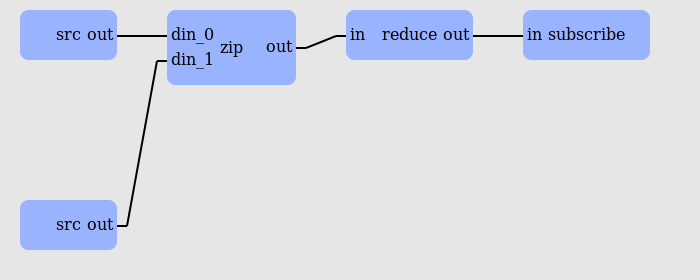

#<CZTop::Socket::PUB:0x55da1c3cbf90 last_endpoint="tcp://127.0.0.1:60053">

In [6]:
bd = IMulvery::BlockDiagram.from_observable(result)
IRuby.display(bd.build_map, mime: "image/png")

## optimizerを用いたチューニング

Mulveryの新機能である `optimizer` を用いてハードウェアのチューニングを行います．  
といってもこのサンプルはシンプルすぎてできることはありません・・・

In [7]:
# result.optimize(Mulvery::Optimizers::pipeline)